In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms, datasets
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [ ]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

# Data augmentation and transformation setup
def get_transforms(aug_type="standard"):
    if aug_type == "standard":
        train_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    elif aug_type == "strong":
        train_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    else:
        raise ValueError("Unknown aug_type")

    test_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transforms, test_transforms

# Data loader preparation
def get_dataloaders(train_dir, test_dir, train_transform, test_transform, batch_size=128):
    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, test_loader, train_dataset.classes

# SENet components
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# SENet architecture
class SEResNet18(nn.Module):
    def __init__(self, num_classes=2, dropout=False):
        super(SEResNet18, self).__init__()
        original_resnet = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        self.features = nn.Sequential(*list(original_resnet.children())[:-2])
        self.se = SEBlock(512)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential()
        if dropout:
            self.fc.add_module('dropout', nn.Dropout(0.5))
        self.fc.add_module('linear', nn.Linear(512, num_classes))

    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Model selection
def get_model(model_name="resnet", num_classes=2, dropout=False):
    if model_name == "resnet":
        model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        num_features = model.fc.in_features
        if dropout:
            model.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(num_features, num_classes)
            )
        else:
            model.fc = nn.Linear(num_features, num_classes)
    elif model_name == "senet":
        model = SEResNet18(num_classes=num_classes, dropout=dropout)
    else:
        raise ValueError("Unsupported model name")
    return model

# Enhanced training function with integrated evaluation
def train_model(model, train_loader, test_loader, class_names, epochs=10, lr=0.001, optimizer_type="adam"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Optimizer selection
    if optimizer_type == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Training metrics storage
    train_loss_list = []
    val_acc_list = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        # Validation phase
        avg_loss = running_loss / len(train_loader)
        train_loss_list.append(avg_loss)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_acc_list.append(val_acc)
        print(f"Epoch {epoch+1}: Train Loss={avg_loss:.4f}, Val Acc={val_acc:.2f}%")

    # Final evaluation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    class_report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)

    return model, train_loss_list, val_acc_list, accuracy, precision, recall, f1, class_report, cm



--- Running Experiment A ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]
Epoch 1/10: 100%|██████████| 75/75 [12:53<00:00, 10.32s/it, loss=0.286]


Epoch 1: Train Loss=0.5548, Val Acc=79.68%


Epoch 2/10: 100%|██████████| 75/75 [00:42<00:00,  1.75it/s, loss=0.486]


Epoch 2: Train Loss=0.3099, Val Acc=85.05%


Epoch 3/10: 100%|██████████| 75/75 [00:42<00:00,  1.75it/s, loss=0.182]


Epoch 3: Train Loss=0.2281, Val Acc=79.34%


Epoch 4/10: 100%|██████████| 75/75 [00:42<00:00,  1.75it/s, loss=0.148]


Epoch 4: Train Loss=0.2068, Val Acc=93.63%


Epoch 5/10: 100%|██████████| 75/75 [00:42<00:00,  1.78it/s, loss=0.237]


Epoch 5: Train Loss=0.1829, Val Acc=87.71%


Epoch 6/10: 100%|██████████| 75/75 [00:43<00:00,  1.71it/s, loss=0.222]


Epoch 6: Train Loss=0.1463, Val Acc=92.04%


Epoch 7/10: 100%|██████████| 75/75 [00:42<00:00,  1.77it/s, loss=0.0281]


Epoch 7: Train Loss=0.1420, Val Acc=93.29%


Epoch 8/10: 100%|██████████| 75/75 [00:42<00:00,  1.78it/s, loss=0.0653]


Epoch 8: Train Loss=0.1222, Val Acc=93.92%


Epoch 9/10: 100%|██████████| 75/75 [00:44<00:00,  1.69it/s, loss=0.0303]


Epoch 9: Train Loss=0.1026, Val Acc=91.71%


Epoch 10/10: 100%|██████████| 75/75 [00:43<00:00,  1.73it/s, loss=0.045]


Epoch 10: Train Loss=0.1151, Val Acc=92.13%
Experiment A Final Accuracy: 92.13%

--- Running Experiment B ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/10: 100%|██████████| 75/75 [00:45<00:00,  1.63it/s, loss=0.295]


Epoch 1: Train Loss=0.5075, Val Acc=84.96%


Epoch 2/10: 100%|██████████| 75/75 [00:44<00:00,  1.69it/s, loss=0.34]


Epoch 2: Train Loss=0.2616, Val Acc=86.92%


Epoch 3/10: 100%|██████████| 75/75 [00:42<00:00,  1.77it/s, loss=0.142]


Epoch 3: Train Loss=0.2302, Val Acc=89.46%


Epoch 4/10: 100%|██████████| 75/75 [00:42<00:00,  1.77it/s, loss=0.127]


Epoch 4: Train Loss=0.1660, Val Acc=91.46%


Epoch 5/10: 100%|██████████| 75/75 [00:42<00:00,  1.76it/s, loss=0.213]


Epoch 5: Train Loss=0.1477, Val Acc=91.75%


Epoch 6/10: 100%|██████████| 75/75 [00:43<00:00,  1.73it/s, loss=0.155]


Epoch 6: Train Loss=0.1445, Val Acc=90.13%


Epoch 7/10: 100%|██████████| 75/75 [00:42<00:00,  1.76it/s, loss=0.145]


Epoch 7: Train Loss=0.1226, Val Acc=91.21%


Epoch 8/10: 100%|██████████| 75/75 [00:42<00:00,  1.76it/s, loss=0.0834]


Epoch 8: Train Loss=0.0984, Val Acc=93.92%


Epoch 9/10: 100%|██████████| 75/75 [00:43<00:00,  1.72it/s, loss=0.188]


Epoch 9: Train Loss=0.0907, Val Acc=91.13%


Epoch 10/10: 100%|██████████| 75/75 [00:42<00:00,  1.75it/s, loss=0.196]


Epoch 10: Train Loss=0.0873, Val Acc=85.30%
Experiment B Final Accuracy: 85.30%

--- Running Experiment C ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/10: 100%|██████████| 75/75 [01:24<00:00,  1.12s/it, loss=0.415]


Epoch 1: Train Loss=0.6363, Val Acc=68.97%


Epoch 2/10: 100%|██████████| 75/75 [01:22<00:00,  1.10s/it, loss=0.345]


Epoch 2: Train Loss=0.3549, Val Acc=87.92%


Epoch 3/10: 100%|██████████| 75/75 [01:25<00:00,  1.13s/it, loss=0.225]


Epoch 3: Train Loss=0.2821, Val Acc=88.80%


Epoch 4/10: 100%|██████████| 75/75 [01:22<00:00,  1.10s/it, loss=0.281]


Epoch 4: Train Loss=0.2430, Val Acc=88.55%


Epoch 5/10: 100%|██████████| 75/75 [01:53<00:00,  1.52s/it, loss=0.138]


Epoch 5: Train Loss=0.2042, Val Acc=89.38%


Epoch 6/10: 100%|██████████| 75/75 [01:22<00:00,  1.11s/it, loss=0.232]


Epoch 6: Train Loss=0.1972, Val Acc=87.01%


Epoch 7/10: 100%|██████████| 75/75 [01:24<00:00,  1.13s/it, loss=0.315]


Epoch 7: Train Loss=0.1799, Val Acc=92.00%


Epoch 8/10: 100%|██████████| 75/75 [01:22<00:00,  1.10s/it, loss=0.161]


Epoch 8: Train Loss=0.1569, Val Acc=89.84%


Epoch 9/10: 100%|██████████| 75/75 [01:22<00:00,  1.11s/it, loss=0.156]


Epoch 9: Train Loss=0.1569, Val Acc=88.75%


Epoch 10/10: 100%|██████████| 75/75 [01:22<00:00,  1.10s/it, loss=0.151]


Epoch 10: Train Loss=0.1604, Val Acc=93.92%
Experiment C Final Accuracy: 93.92%

--- Running Experiment D ---


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/10: 100%|██████████| 75/75 [00:44<00:00,  1.70it/s, loss=1.75]


Epoch 1: Train Loss=2.2783, Val Acc=77.47%


Epoch 2/10: 100%|██████████| 75/75 [00:42<00:00,  1.77it/s, loss=0.699]


Epoch 2: Train Loss=1.1474, Val Acc=86.88%


Epoch 3/10: 100%|██████████| 75/75 [00:42<00:00,  1.75it/s, loss=0.468]


Epoch 3: Train Loss=0.6323, Val Acc=89.75%


Epoch 4/10: 100%|██████████| 75/75 [00:44<00:00,  1.68it/s, loss=0.455]


Epoch 4: Train Loss=0.4345, Val Acc=91.42%


Epoch 5/10: 100%|██████████| 75/75 [00:42<00:00,  1.77it/s, loss=0.347]


Epoch 5: Train Loss=0.3302, Val Acc=93.04%


Epoch 6/10: 100%|██████████| 75/75 [00:42<00:00,  1.78it/s, loss=0.247]


Epoch 6: Train Loss=0.2673, Val Acc=93.67%


Epoch 7/10: 100%|██████████| 75/75 [00:44<00:00,  1.70it/s, loss=0.228]


Epoch 7: Train Loss=0.2280, Val Acc=94.25%


Epoch 8/10: 100%|██████████| 75/75 [00:41<00:00,  1.80it/s, loss=0.165]


Epoch 8: Train Loss=0.2080, Val Acc=95.00%


Epoch 9/10: 100%|██████████| 75/75 [00:42<00:00,  1.77it/s, loss=0.145]


Epoch 9: Train Loss=0.1812, Val Acc=95.13%


Epoch 10/10: 100%|██████████| 75/75 [00:42<00:00,  1.75it/s, loss=0.115]


Epoch 10: Train Loss=0.1649, Val Acc=95.50%
Experiment D Final Accuracy: 95.50%

Best Model: Experiment D with Accuracy: 95.50%

SENet Final Evaluation on Test Set for Experiment D:


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


SENet Test dataset Accuracy: 95.50%
SENet Test dataset Precision: 95.55%
SENet Test dataset Recall: 95.50%
SENet Test dataset F1-score: 95.50%

SENet Final classification report:
              precision    recall  f1-score   support

 Agriculture       0.96      0.98      0.97       160
     Airport       0.93      0.90      0.91       160
       Beach       0.98      0.94      0.96       160
        City       0.91      0.97      0.94       160
      Desert       0.97      0.98      0.98       160
      Forest       0.97      0.97      0.97       160
   Grassland       0.99      0.97      0.98       160
     Highway       0.97      0.93      0.95       160
        Lake       0.92      0.94      0.93       160
    Mountain       0.94      0.97      0.95       160
     Parking       1.00      0.98      0.99       160
        Port       0.99      0.98      0.98       160
     Railway       0.92      0.89      0.91       160
 Residential       0.98      0.99      0.98       160
       Riv

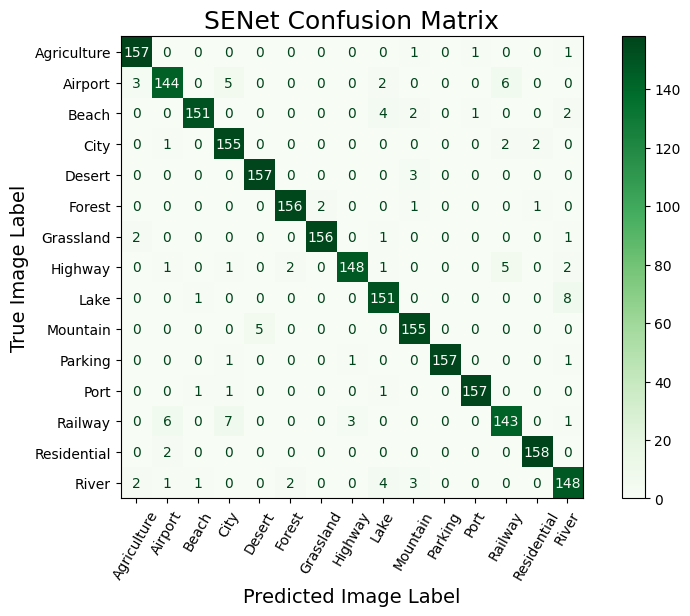

In [ ]:
if __name__ == "__main__":
    set_seed(42)
    train_dir = '/content/drive/MyDrive/COMP9517_ZXCZH/train'
    test_dir = '/content/drive/MyDrive/COMP9517_ZXCZH/test'

    experiments = [
        {"name": "A", "model": "senet", "aug": "standard", "dropout": True, "optimizer": "adam"},
        {"name": "B", "model": "senet", "aug": "standard", "dropout": False, "optimizer": "adam"},
        {"name": "C", "model": "senet", "aug": "strong", "dropout": True, "optimizer": "adam"},
        {"name": "D", "model": "senet", "aug": "standard", "dropout": True, "optimizer": "sgd"}
    ]

    all_results = []
    best_accuracy = 0.0
    best_model_info = {}

    for exp in experiments:
        print(f"\n--- Running Experiment {exp['name']} ---")
        train_transform, test_transform = get_transforms(aug_type=exp['aug'])
        train_loader, test_loader, classes = get_dataloaders(train_dir, test_dir, train_transform, test_transform)

        model = get_model(
            model_name=exp['model'],
            num_classes=len(classes),
            dropout=exp['dropout']
        )

        model, train_loss, val_acc, accuracy, precision, recall, f1, class_report, cm = train_model(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            class_names=classes,
            epochs=10,
            lr=0.001,
            optimizer_type=exp['optimizer']
        )

        print(f"Experiment {exp['name']} Final Accuracy: {accuracy * 100:.2f}%")
        all_results.append({
            "name": exp['name'],
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "model": model,
            "classes": classes,
            "test_loader": test_loader
        })

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_info = {
                "experiment": exp['name'],
                "model": model,
                "classes": classes,
                "test_loader": test_loader
            }

    print(f"\nBest Model: Experiment {best_model_info['experiment']} with Accuracy: {best_accuracy * 100:.2f}%")

    # SENet Final Evaluation
    from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    print(f"\nSENet Final Evaluation on Test Set for Experiment {best_model_info['experiment']}:")
    model = best_model_info['model']
    classes = best_model_info['classes']
    test_loader = best_model_info['test_loader']

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Use accuracy, precision, recall and f1 as the evaluation metrics.
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"SENet Test dataset Accuracy: {accuracy * 100:.2f}%")
    print(f"SENet Test dataset Precision: {precision * 100:.2f}%")
    print(f"SENet Test dataset Recall: {recall * 100:.2f}%")
    print(f"SENet Test dataset F1-score: {f1 * 100:.2f}%")

    # SENet Classification report.
    print("\nSENet Final classification report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    # SENet Confusion matrix:
    cm = confusion_matrix(all_labels, all_preds)
    fig, ax = plt.subplots(figsize=(10, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Greens', xticks_rotation=60, ax=ax)
    plt.title("SENet Confusion Matrix", fontsize=18)
    plt.xlabel("Predicted Image Label", fontsize=14)
    plt.ylabel("True Image Label", fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()